In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import cv2

In [2]:
# Load data
def load_data():
    data = np.load('/kaggle/input/lung-cancer/lung_dataset_interpolated.npz')
    full = data['full_slices']
    nodules = data['nodules']
    labels = data['tumor_classes']

    return full, nodules, labels

In [3]:
full_slices, nodules, labels = load_data()

In [4]:
def scale_images(images):
    min_vals = images.min(axis=(1, 2), keepdims=True)  # Min per image
    max_vals = images.max(axis=(1, 2), keepdims=True)  # Max per image
    
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1  
    
    return (images - min_vals) / range_vals

In [5]:
def rescale_images_255_uint8(images):
    images *= 255
    return np.array(images).astype('uint8')

In [6]:
def apply_median_blur(images): 
    return [cv2.medianBlur(image, 3) for image in images]

In [7]:
def apply_hist_equalization(images):
    return [cv2.equalizeHist(image) for image in images]

In [8]:
def apply_clahe(images):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return [clahe.apply(image) for image in images]

In [9]:
def apply_open_morph(images):
    kernel = np.ones((3, 3), np.uint8)
    return [cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel) for image in images]

In [10]:
def expand_channels(images, channels=3): 
    return np.stack([images], axis=-1)

In [11]:
def expand_dims(images):
    return np.expand_dims(images, axis=-1)

In [12]:
def preprocess_images(images, steps): 
    for step in steps:
        images = step(images)
    return np.array(images)

In [13]:
preprocessing_pipeline = [
    scale_images,
    rescale_images_255_uint8,
    apply_median_blur,
    apply_hist_equalization,
    apply_clahe,
    apply_open_morph,
    # expand_channels,
    expand_dims,
]

In [14]:
full_slices_3 = preprocess_images(full_slices, preprocessing_pipeline)
nodules_3 = preprocess_images(nodules, preprocessing_pipeline)

In [15]:
# labels = [0 if label < 4 else 1 for label in labels]

In [16]:
full_input_shape = full_slices_3.shape[1:]
nodules_input_shape = nodules_3.shape[1:]

print(full_input_shape, nodules_input_shape)

(512, 512, 1) (138, 138, 1)


In [17]:
# Load pre-trained model
def generate_embeddings(data): 
    data = tf.keras.applications.xception.preprocess_input(data)
    model = tf.keras.applications.Xception(input_shape=data.shape[1:], include_top=False, weights='imagenet')

    gap_layer = tf.keras.layers.GlobalAveragePooling2D()(model.output)
    feature_extractor = Model(inputs=model.input, outputs=gap_layer)

    features = feature_extractor.predict(data)
    return features

In [18]:
model_path = '/kaggle/input/medusa-nodules-5-class/keras/default/1/CustomCNN_0.6465.keras'

def medusa_embeddings(data):
    model = tfk.models.load_model(model_path)
    model.trainable = False
    out_layer = model.get_layer('dense')

    feature_extractor = Model(inputs=model.input, outputs=out_layer.output)
    feature_extractor.summary()
    features = feature_extractor.predict(data)
    return features

In [19]:
import matplotlib.cm as cm

def plot_tsne(features_2d, labels, title=''): 
    unique_labels = np.unique(labels)
    
    # Generate distinct colors from viridis colormap
    viridis = cm.get_cmap('viridis', len(unique_labels))  # Get 5 discrete colors
    label_colors = {label: viridis(i) for i, label in enumerate(unique_labels)}
    
    plt.figure(figsize=(8, 6), dpi=300)
    for label in unique_labels:
        indices = labels == label
        plt.scatter(features_2d[indices, 0], features_2d[indices, 1], 
                    color=label_colors[label], label=f"Class {label}", alpha=0.7, s=10)
    
    # scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', alpha=0.7, s=10)
    # plt.colorbar(scatter, label="Class Label")
    plt.legend(title="Malignancy score")
    plt.title(f"t-SNE Visualization of {title} Embeddings")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.savefig(f'/kaggle/working/t-SNE_{title}.png', bbox_inches='tight')
    plt.show()

def plot_tsne3D(features_3d, labels, title=''): 
    unique_labels = np.unique(labels)
    
    # Generate distinct colors from viridis colormap
    viridis = cm.get_cmap('viridis', len(unique_labels))  # Get 5 discrete colors
    label_colors = {label: viridis(i) for i, label in enumerate(unique_labels)}
    
    fig = plt.figure(figsize=(10, 8), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    
    for label in unique_labels:
        indices = labels == label
        ax.scatter(features_3d[indices, 0], features_3d[indices, 1], features_3d[indices, 2], 
                   color=label_colors[label], label=f"Class {label}", alpha=0.7, s=10)
    
    # scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', alpha=0.7, s=10)
    # plt.colorbar(scatter, label="Class Label")
    ax.set_title(f"t-SNE Visualization of {title} Embeddings")
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.set_zlabel("t-SNE Component 3")
    ax.legend(title="Malignancy score")
    
    plt.savefig(f'/kaggle/working/t-SNE_3D_{title}.png', bbox_inches='tight')
    plt.show()

In [20]:
def run_tsne(data, labels, title=''): 
    tsne = TSNE(n_components=2, perplexity=30)
    embeddings = medusa_embeddings(data)
    features = tsne.fit_transform(embeddings)
    plot_tsne(features, labels, title)

def run_tsne3D(data, labels, title=''):
    tsne = TSNE(n_components=3, perplexity=30) 
    embeddings = medusa_embeddings(data)
    features = tsne.fit_transform(embeddings)
    plot_tsne3D(features, labels, title)

In [21]:
# run_tsne(full_slices_3, labels, 'Full-slice (Binary)')
run_tsne(nodules_3, labels, 'Nodule (Binary)')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 138, 138, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_initial (Conv2D)     │ (None, 136, 136, 64)   │            640 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_initial          │ (None, 68, 68, 64)     │              0 │ conv_initial[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_max_pool      │ (None, 68, 68, 64)     │              0 │ max_pool_initial[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_1x1_conv      │ (None, 68, 68, 64)     │          4,160 │ max_pool_initial[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_3x3_conv      │ (None, 68, 68, 64)     │         36,928 │ max_pool_initial[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_5x5_conv      │ (None, 68, 68, 128)    │        204,928 │ max_pool_initial[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_pool_1x1_conv │ (None, 68, 68, 256)    │         16,640 │ inception_1_max_pool[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_concat        │ (None, 68, 68, 512)    │              0 │ inception_1_1x1_conv[… │
│ (Concatenate)             │                        │                │ inception_1_3x3_conv[… │
│                           │                        │                │ inception_1_5x5_conv[… │
│                           │                        │                │ inception_1_pool_1x1_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout_1         │ (None, 68, 68, 512)    │              0 │ inception_1_concat[0]… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduce_channels_3         │ (None, 68, 68, 128)    │         65,664 │ spatial_dropout_1[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 68, 68, 128)    │              0 │ reduce_channels_3[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_2_max_pool      │ (None, 68, 68, 128)    │              0 │ dropout_3[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_2_1x1_conv 

 Total params: 1,443,840 (5.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,443,840 (5.51 MB)

74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step


<ipython-input-19-619142c44acd>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', len(unique_labels))  # Get 5 discrete colors


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 138, 138, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_initial (Conv2D)     │ (None, 136, 136, 64)   │            640 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_initial          │ (None, 68, 68, 64)     │              0 │ conv_initial[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_max_pool      │ (None, 68, 68, 64)     │              0 │ max_pool_initial[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_1x1_conv      │ (None, 68, 68, 64)     │          4,160 │ max_pool_initial[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_3x3_conv      │ (None, 68, 68, 64)     │         36,928 │ max_pool_initial[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_5x5_conv      │ (None, 68, 68, 128)    │        204,928 │ max_pool_initial[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_pool_1x1_conv │ (None, 68, 68, 256)    │         16,640 │ inception_1_max_pool[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_concat        │ (None, 68, 68, 512)    │              0 │ inception_1_1x1_conv[… │
│ (Concatenate)             │                        │                │ inception_1_3x3_conv[… │
│                           │                        │                │ inception_1_5x5_conv[… │
│                           │                        │                │ inception_1_pool_1x1_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout_1         │ (None, 68, 68, 512)    │              0 │ inception_1_concat[0]… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduce_channels_3         │ (None, 68, 68, 128)    │         65,664 │ spatial_dropout_1[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 68, 68, 128)    │              0 │ reduce_channels_3[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_2_max_pool      │ (None, 68, 68, 128)    │              0 │ dropout_3[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_2_1x1_conv 

 Total params: 1,443,840 (5.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,443,840 (5.51 MB)

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


<ipython-input-19-619142c44acd>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', len(unique_labels))  # Get 5 discrete colors


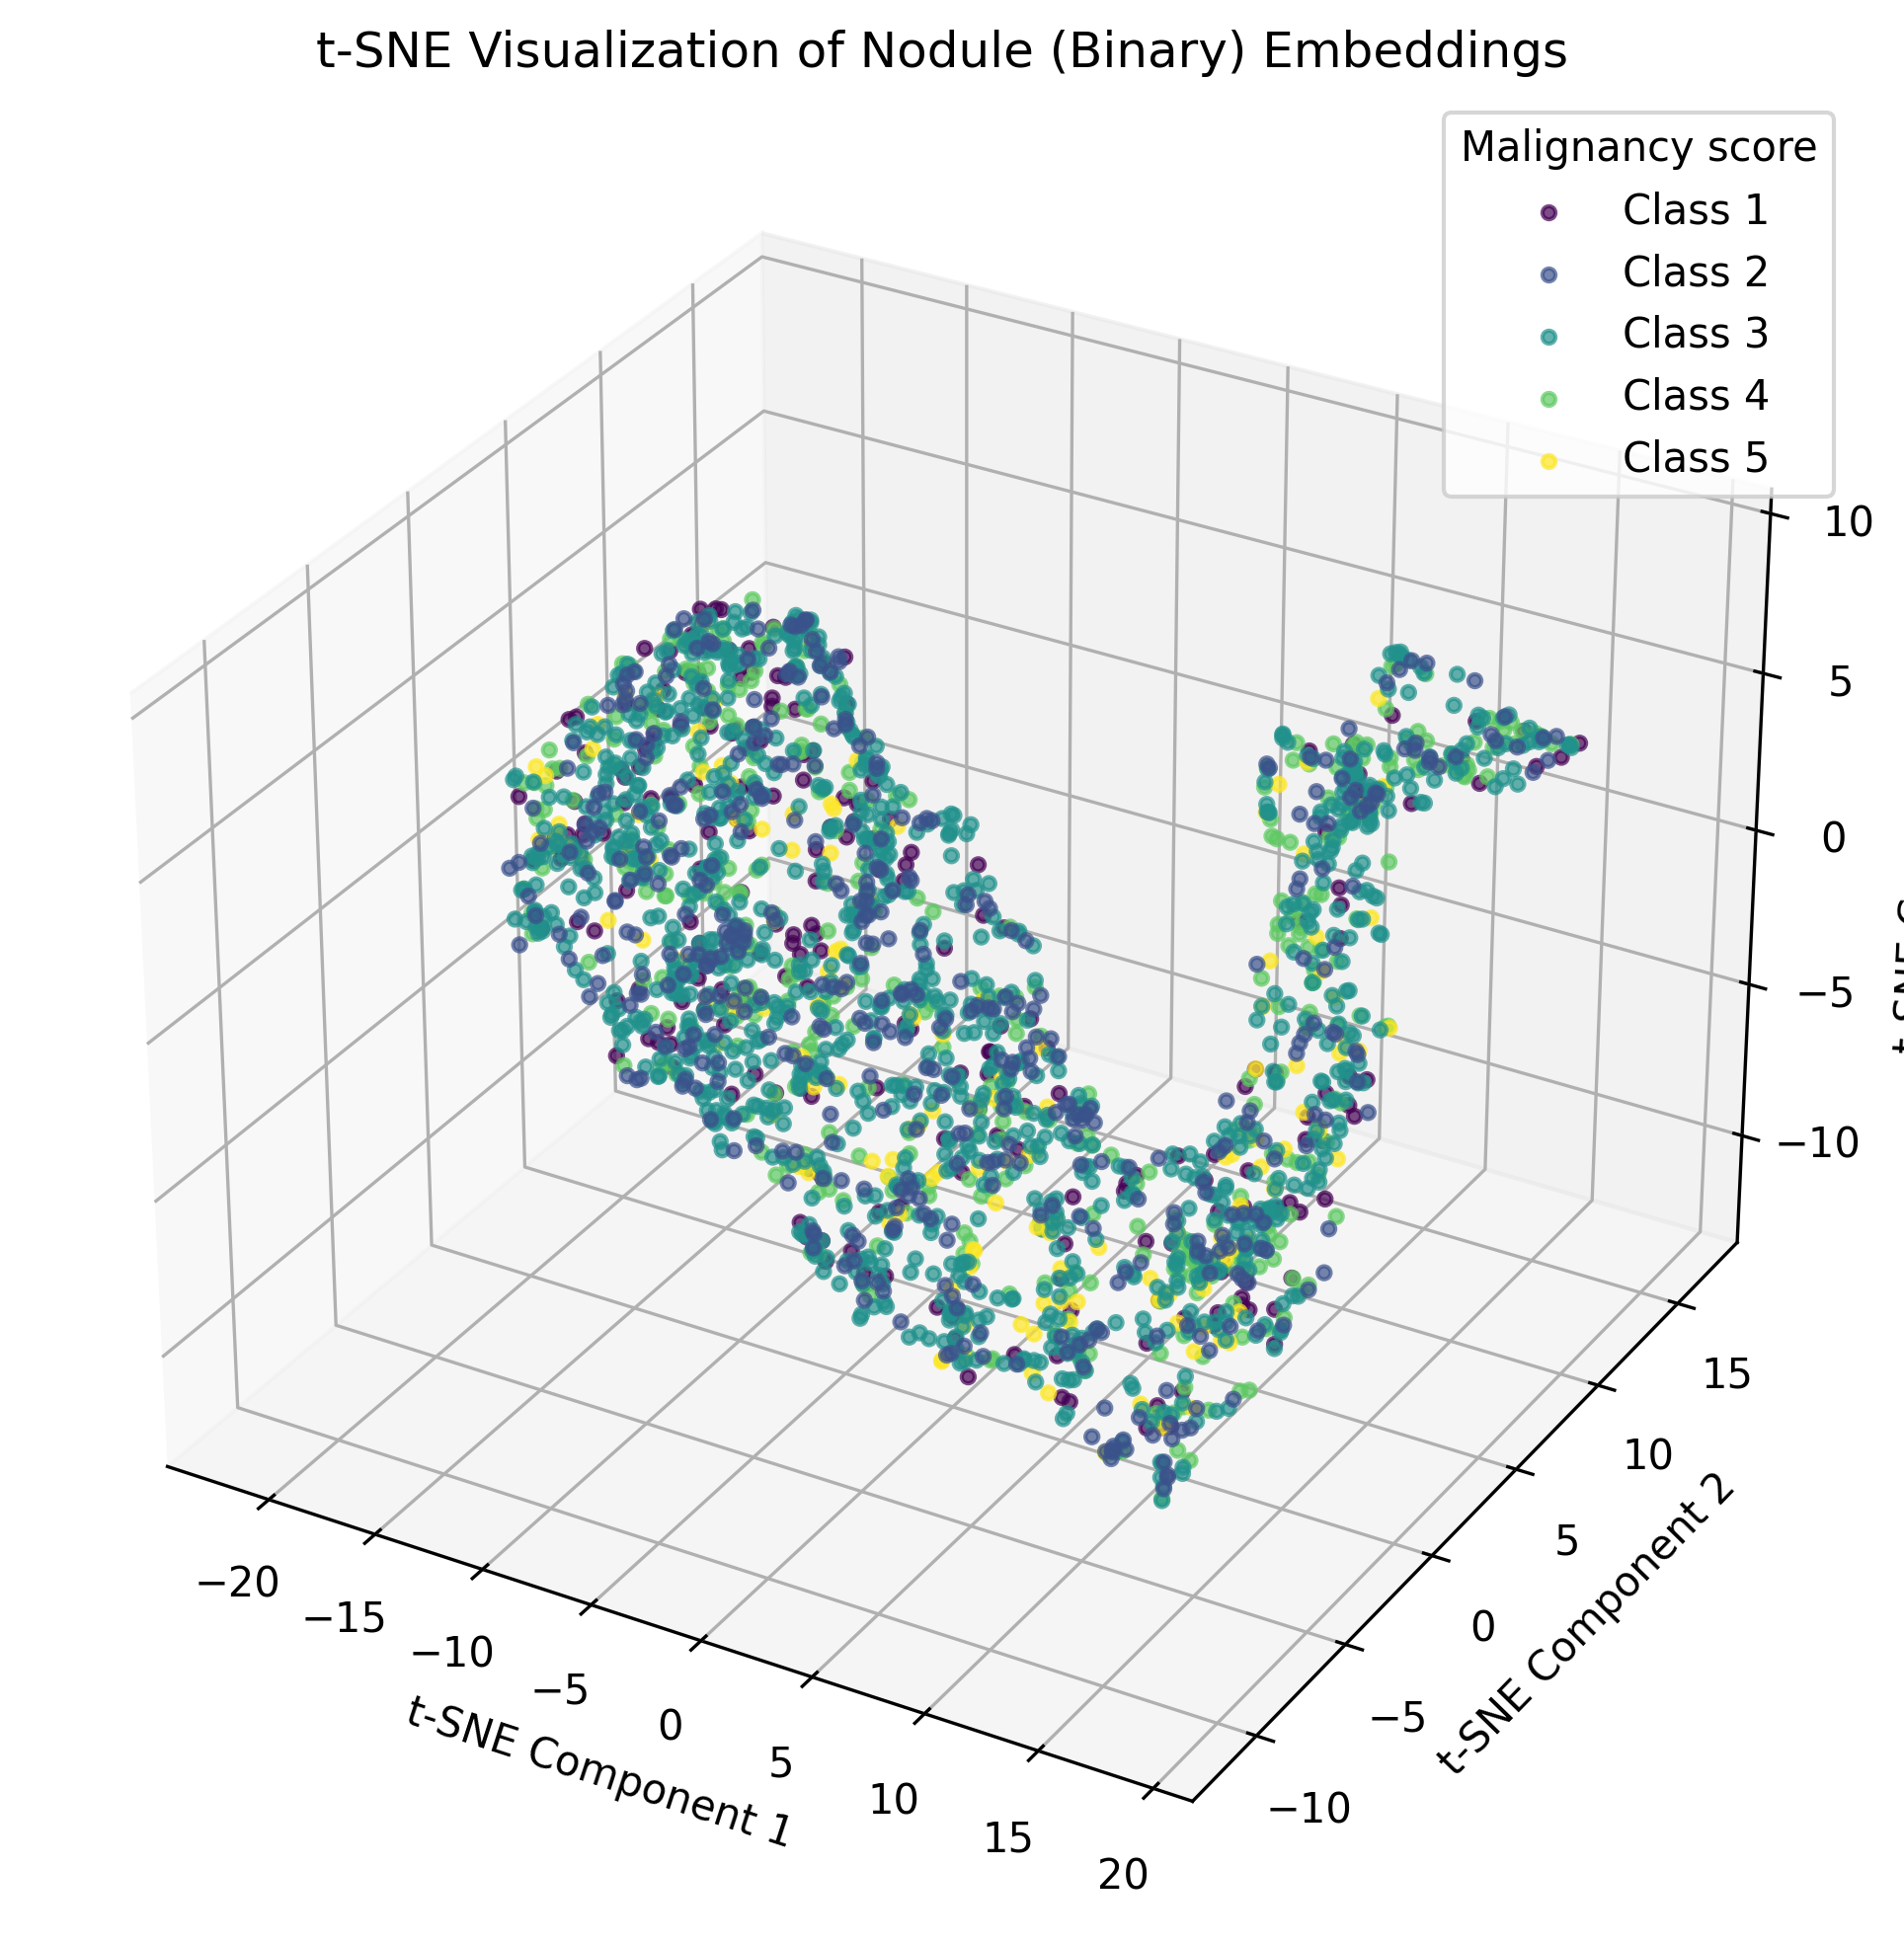

In [22]:
run_tsne3D(nodules_3, labels, 'Nodule (Binary)')

In [ ]:
cv2.destroyAllWindows()